# Testing with the original dataset, imbalanced on each class.
### Using MobileNet

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, Xception
import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
import os

2024-06-12 15:09:25.179850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 15:09:25.180053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 15:09:25.383595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
pretrained_models = {
    'mnet': MobileNet,
    'mnet2': MobileNetV2,
    'mnet3s': MobileNetV3Small,
    'xcept': Xception,
}

In [6]:
# Variables for reusability, only change EPOCHS if needed, keep rest as is.
VAL_SPLIT   = 0.2
TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE  = 32
EPOCHS      = 15

In [5]:
data_dir = "../input/agrovision-dataset-1k/train"

In [7]:
datagen_train = ImageDataGenerator(rescale            = 1./255,
                                   validation_split   = VAL_SPLIT,
                                   rotation_range     = 20,
                                   width_shift_range  = 0.2,
                                   height_shift_range = 0.2, 
                                   shear_range        = 0.2, 
                                   zoom_range         = 0.2, 
                                   horizontal_flip    = True, 
                                   vertical_flip      = True, 
                                   fill_mode          = 'nearest')    
                                    
train_generator = datagen_train.flow_from_directory(data_dir,
                                                    seed        = 42,
                                                    target_size = TARGET_SIZE,
                                                    batch_size  = BATCH_SIZE, 
                                                    shuffle     = True,
                                                    subset      = 'training')

Found 18031 images belonging to 19 classes.


In [ ]:
datagen_val = ImageDataGenerator(rescale          = 1./255, 
                                 validation_split = 0.2) 

val_generator = datagen_val.flow_from_directory(data_dir,
                                                seed        = 42,
                                                target_size = TARGET_SIZE,
                                                batch_size  = BATCH_SIZE, 
                                                shuffle     = True,
                                                subset      = 'validation')

In [9]:
train_generator.class_indices

{'cassava-bacterialblight': 0,
 'cassava-brownstreak': 1,
 'cassava-greenmottle': 2,
 'cassava-healthy': 3,
 'cassava-mosaic': 4,
 'corn-blight': 5,
 'corn-grayleafspot': 6,
 'corn-healthy': 7,
 'corn-rust': 8,
 'rice-bacterialblight': 9,
 'rice-brownspot': 10,
 'rice-healthy': 11,
 'rice-leafblast': 12,
 'rice-tungro': 13,
 'sugarcane-healthy': 14,
 'sugarcane-mosaic': 15,
 'sugarcane-redrot': 16,
 'sugarcane-rust': 17,
 'sugarcane-yellow': 18}

In [7]:
# def create_model():
#     model = tf.keras.models.Sequential([
#             tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
#             tf.keras.layers.MaxPooling2D((2, 2)),
#             tf.keras.layers.Flatten(),
#             tf.keras.layers.Dense(64, activation='relu'),
#             tf.keras.layers.Dense(19, activation='softmax'),
#     ])

#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=[keras.metrics.CategoricalAccuracy(), 'accuracy'])
    
#     return model

In [16]:
def create_model(preTrained = 'mnet'):
    inputs = keras.Input(shape = INPUT_SHAPE)
    PreTrainedModel = pretrained_models.get(preTrained)

    if PreTrainedModel is None:
        raise ValueError(f"Unsupported pre-trained model: {preTrained}")

    preTrained = PreTrainedModel(input_shape = INPUT_SHAPE, include_top = False, weights = 'imagenet')
    # preTrained.trainable = False 
    x = preTrained(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation = 'relu')(x)
    x = tf.keras.layers.Dense(19, activation = 'softmax')(x)

    model = tf.keras.Model(inputs = inputs, outputs = x)

    model.compile(optimizer = 'adam',
                  loss      = 'categorical_crossentropy',
                  metrics   = [keras.metrics.CategoricalAccuracy(), 'accuracy'])

    return model

In [9]:
model = create_model('mnet')

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,526,611 (13.45 MB)

 Trainable params: 3,504,723 (13.37 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [11]:
history = model.fit(train_generator,
                    validation_data  = val_generator,
                    epochs           = EPOCHS)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/564 ━━━━━━━━━━━━━━━━━━━━ 45s 81ms/step - accuracy: 0.1250 - categorical_accuracy: 0.1250 - loss: 3.1753   

I0000 00:00:1718170298.566633     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


564/564 ━━━━━━━━━━━━━━━━━━━━ 535s 884ms/step - accuracy: 0.6138 - categorical_accuracy: 0.6138 - loss: 1.1078 - val_accuracy: 0.7499 - val_categorical_accuracy: 0.7499 - val_loss: 0.7512
Epoch 2/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 331s 580ms/step - accuracy: 0.7768 - categorical_accuracy: 0.7768 - loss: 0.6190 - val_accuracy: 0.8015 - val_categorical_accuracy: 0.8015 - val_loss: 0.5768
Epoch 3/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 326s 572ms/step - accuracy: 0.8131 - categorical_accuracy: 0.8131 - loss: 0.5341 - val_accuracy: 0.7826 - val_categorical_accuracy: 0.7826 - val_loss: 0.6102
Epoch 4/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 328s 575ms/step - accuracy: 0.8205 - categorical_accuracy: 0.8205 - loss: 0.4924 - val_accuracy: 0.7835 - val_categorical_accuracy: 0.7835 - val_loss: 0.6367
Epoch 5/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 326s 572ms/step - accuracy: 0.8247 - categorical_accuracy: 0.8247 - loss: 0.4773 - val_accuracy: 0.8104 - val_categorical_accuracy: 0.8104 - val_loss: 0.5822
Epoch 6/15
564/564 ━━

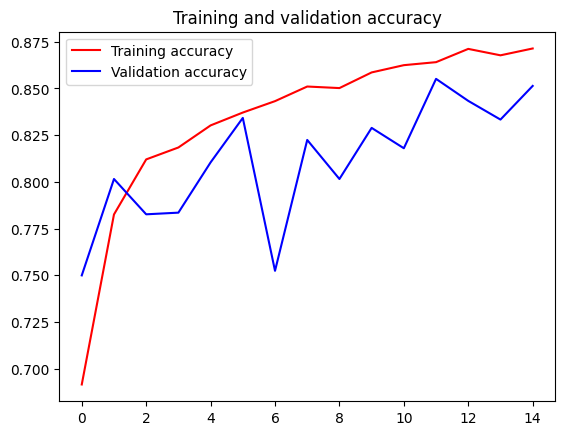

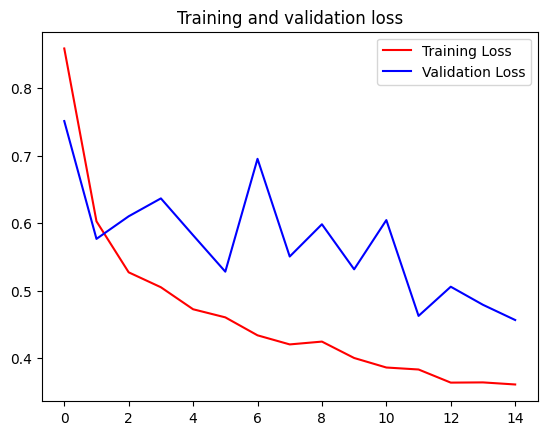

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
model2 = create_model('mnet')

In [18]:
model2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,920,339 (14.95 MB)

 Trainable params: 3,898,451 (14.87 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [20]:
history2 = model2.fit(train_generator,
                    validation_data  = val_generator,
                    epochs           = 50,
                    steps_per_epoch  = 100,
                    validation_steps = 150)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.3914 - categorical_accuracy: 0.3914 - loss: 1.8925 - val_accuracy: 0.3903 - val_categorical_accuracy: 0.3903 - val_loss: 2.5187
Epoch 2/50
  2/100 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.4609 - categorical_accuracy: 0.4609 - loss: 1.2768

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 784ms/step - accuracy: 0.5869 - categorical_accuracy: 0.5869 - loss: 1.1295 - val_accuracy: 0.5630 - val_categorical_accuracy: 0.5630 - val_loss: 1.4083
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 791ms/step - accuracy: 0.6282 - categorical_accuracy: 0.6282 - loss: 0.9850 - val_accuracy: 0.6290 - val_categorical_accuracy: 0.6290 - val_loss: 1.2361
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 759ms/step - accuracy: 0.6741 - categorical_accuracy: 0.6741 - loss: 0.8999 - val_accuracy: 0.6057 - val_categorical_accuracy: 0.6057 - val_loss: 1.1288
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 631ms/step - accuracy: 0.7030 - categorical_accuracy: 0.7030 - loss: 0.7985 - val_accuracy: 0.6393 - val_categorical_accuracy: 0.6393 - val_loss: 1.2178
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 325ms/step - accuracy: 0.7148 - categorical_accuracy: 0.7148 - loss: 0.8183 - val_accuracy: 0.6361 - val_categorical_accuracy: 0.6361 - val_loss: 1.2200
Epoch 7/50
100/100 ━━━━━━━

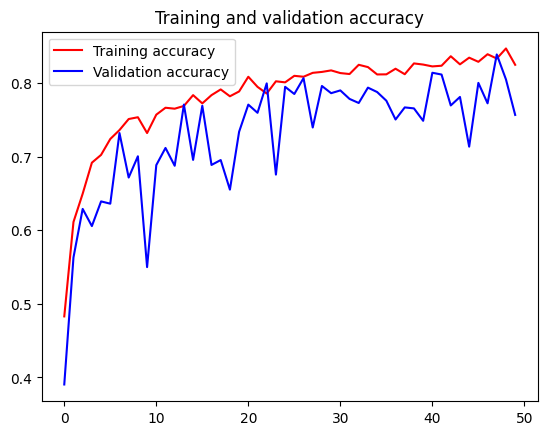

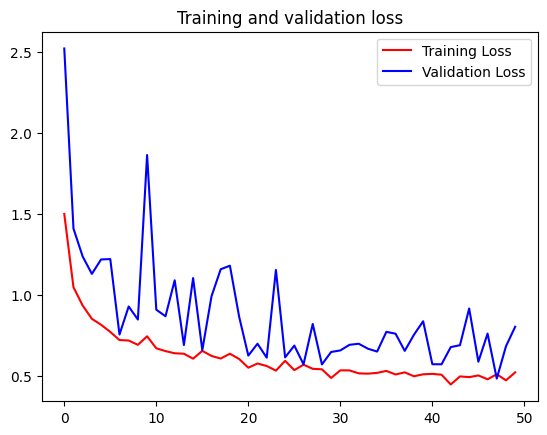

In [22]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(50)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()